# Análise não-linear de séries temporais

Este tipo de análise consiste em um conjunto de metodologias que começaram a ser desenvolvidas na década de 1990 com a finalidade de estudar sistemas complexos. Uma [boa revisão](https://aip.scitation.org/doi/pdf/10.1063/1.4917289?casa_token=J6ENq2j7UZYAAAAA:zHvGR93etcwS0jZPxq1Gu3sw1xPcVefi89Qh3lepPIFxUm6zkQcdnGPXPVbR3Rvo9qg_LFdtlMzQ) deste assunto nos informa que se trata de buscar caracterizar o sistema dinâmico por trás do fenômeno estudado, frequentemente, um sistema caótico deterministico. O Artigo de [Basharat et al.](http://www.cs.ucf.edu/~arslan/Basharat_ICCV09.pdf) mostra uma aplicação muito útil desta metodologia.



In [1]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score as MI
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output, display
import warnings
import ipywidgets as widgets
warnings.filterwarnings("ignore", module='')
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 10.0)

## Reconstrução do espaço de estados
A reconstrução do espaço de estados do sistema dinâmico é a pedra fundamental desta metodologia. Para isso normalmente usamos Retratos de fase $m$-dimensionais atrasados da nossa série $y(t)$:

$$\overrightarrow{R}(t)=\left[y(t), y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)\right]$$

Vamos explorar esta reconstrução com uma série simulada a partir das equações de Rössler.

\begin{align}
\frac{dx}{dt}&=-y-z\\
\frac{dy}{dt}&=x+a y\\
\frac{dz}{dt}&=b + z  (x - c)
\end{align}

In [2]:
def rossler(Y,t,*pars):
    x,y,z = Y
    a,b,c = pars
    return [
        -y-z,
        x+(a*y),
        b+z*(x-c)
    ]

In [11]:
inits = [4,4,5]
a,b,c = 0.2, 0.2, 5.7
trange = np.linspace(0,3000,20000)
res = odeint(rossler,inits,trange, args=(a,b,c))

De acordo com o [teorema de Takens](https://math.stackexchange.com/questions/2262961/understanding-takens-embedding-theorem) sobre delay embedding, nos diz que podemos reconstruir um atrator estranho de dimensão $n$ a partir apenas de uma série temporal $x(t)$  de medidas do sistema dinâmico original usado para reconstruir o atrator em um espaço de fase atrasado de dimensão $m\leq n$: $y(t)=[y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)]$. 

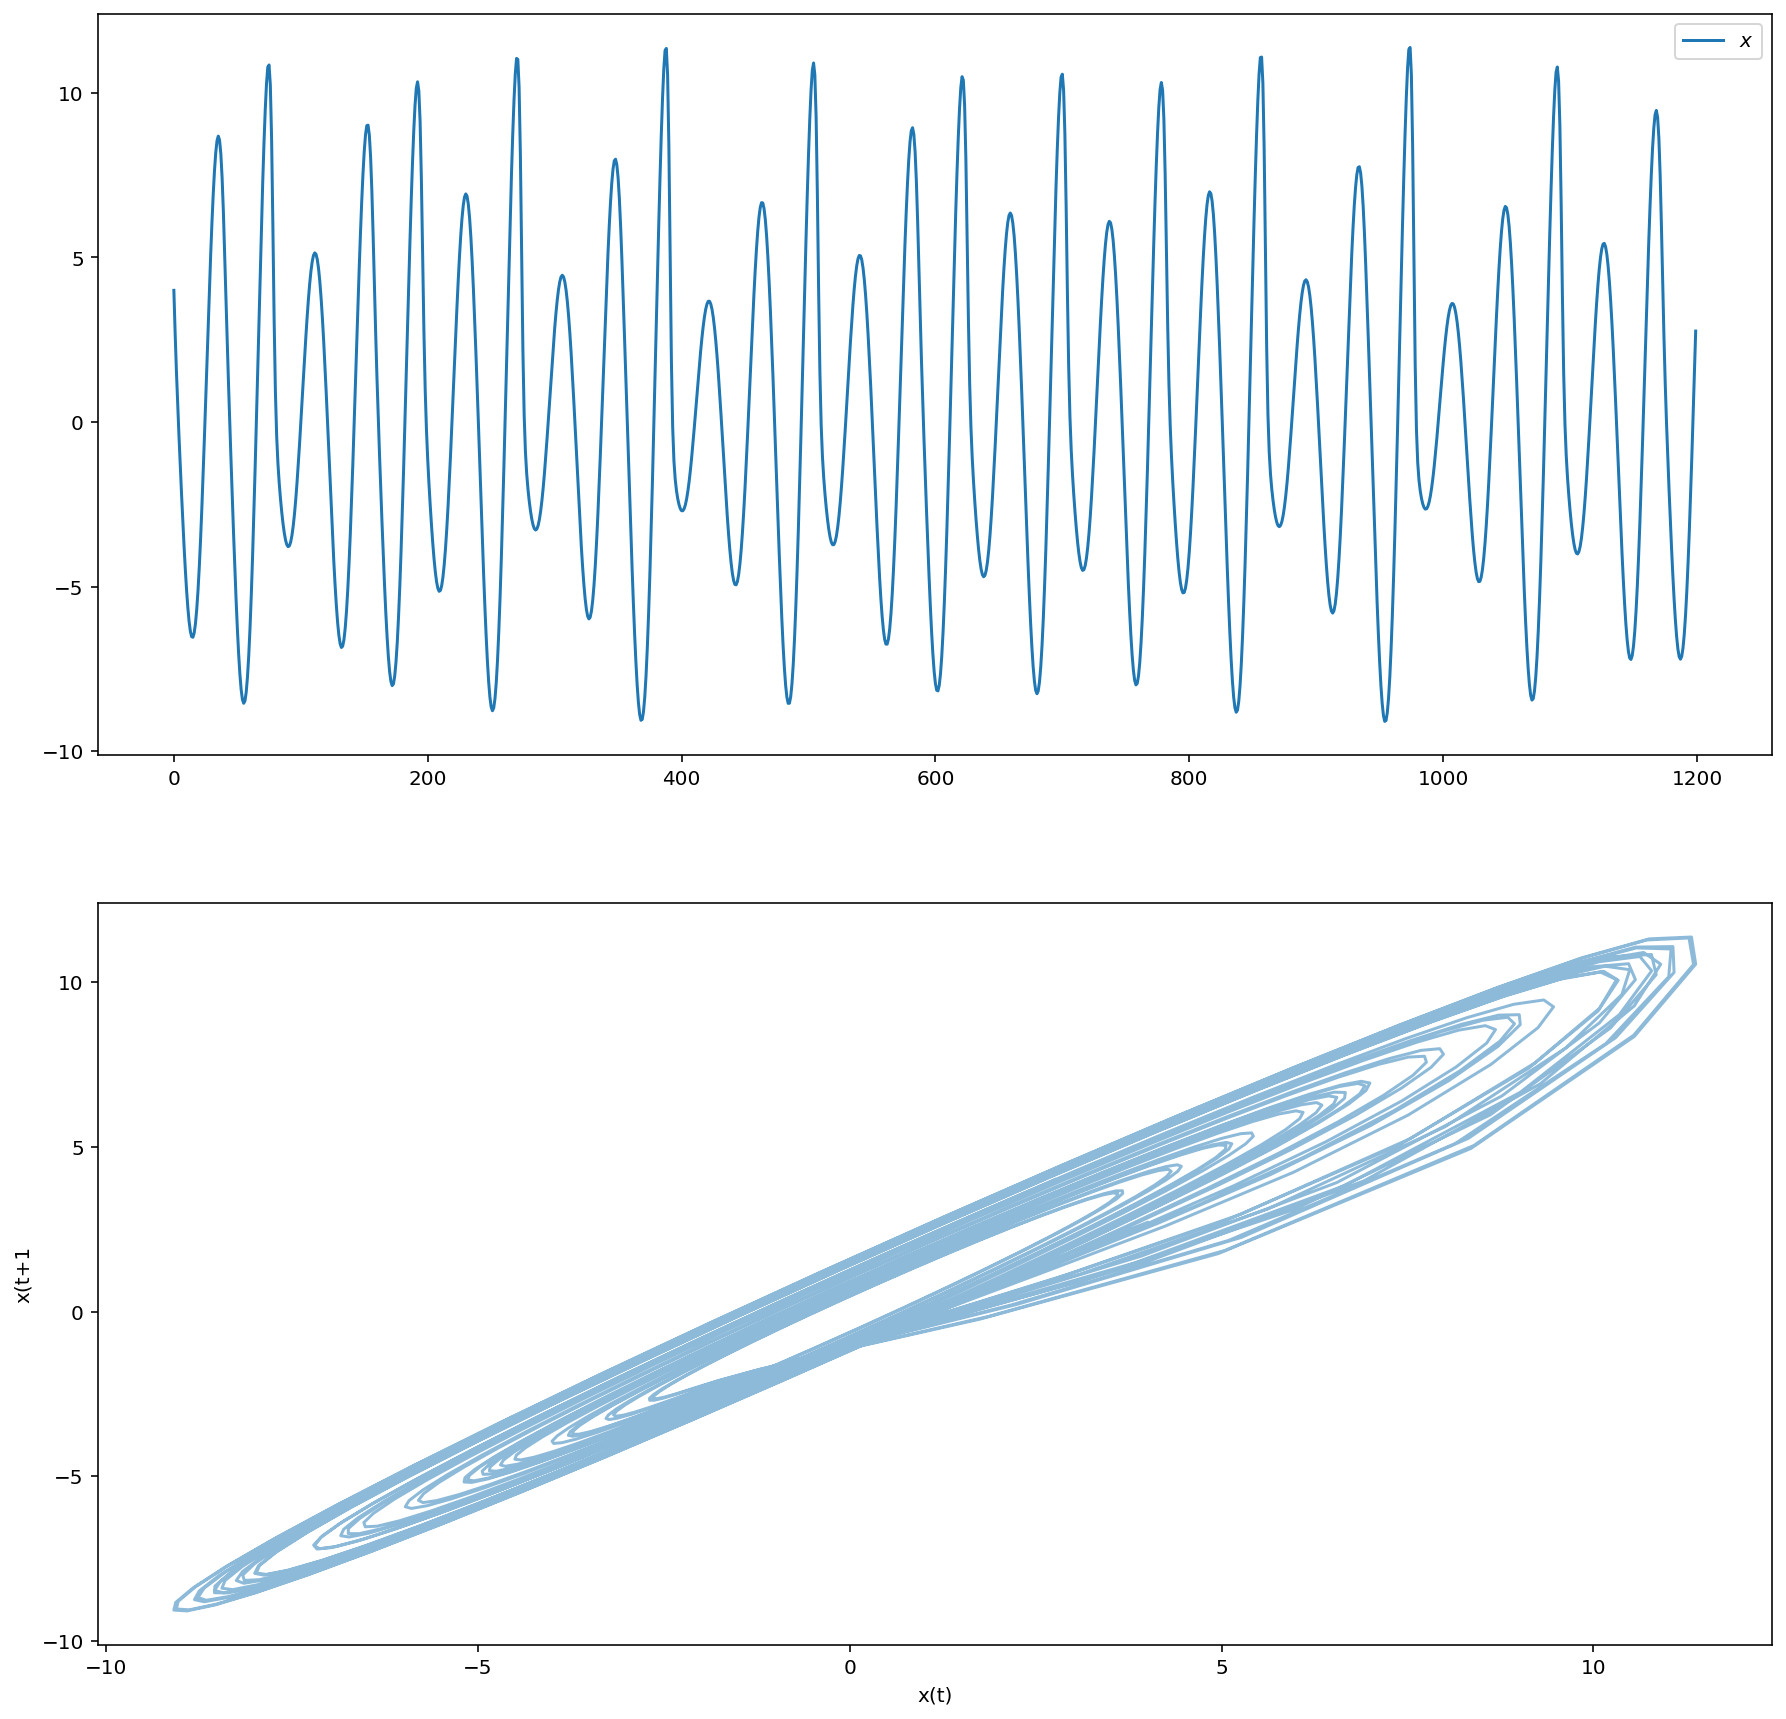

In [12]:
f,[ax1,ax2] = plt.subplots(2,1,figsize=(15,15))
ax1.plot(res[:1200,0], label='$x$');
ax1.legend()
ax2.plot(res[:1200,0],res[1:1201,0], alpha=.5);
ax2.set_xlabel('x(t)')
ax2.set_ylabel('x(t+1');

A series atrasadas com valores de $\tau$ pequenos, tendem a ser muito correlacionadas. Portanto a escolha de $\tau$ é importante. Abaixo temos uma figura interativa que nos permite visualizar o atrator do sistema em 3 dimensões para vários valores de $\tau$. Uma das maneiras mais comuns de se estima o melhor valor de $\tau$ é através da [informação mútua](https://en.wikipedia.org/wiki/Mutual_information) entre as séries, queremos encontrar o menor valor de tau, que minimiza a informação mútua.

Para simplicidade de cálculo podemos obter a informação mútua a partir da correlação:
$$I=-\frac{1}{2}log(1-\rho^2)$$

Esta aproximação pressupõe que ambas as séries têm distribuição Gaussiana.

In [13]:

@interact(tau=widgets.IntSlider(7,0,40,1))
def embed(tau):
    fig = plt.figure()
    ax=fig.gca(projection='3d')
    x,y,z = res[:-2*tau,0],res[tau:-tau,0], res[2*tau:,0]
    mi = MI(x,y)
    ax.plot(x,y,z, '.', alpha=0.5)
    ax.set_title(fr'$\tau={tau}$, Mutual information: {mi}')
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(f'$x+{tau}$')
    ax.set_zlabel(f'$x+{2*tau}$')

#     clear_output(wait=True)
    

interactive(children=(IntSlider(value=7, description='tau', max=40), Output()), _dom_classes=('widget-interact…

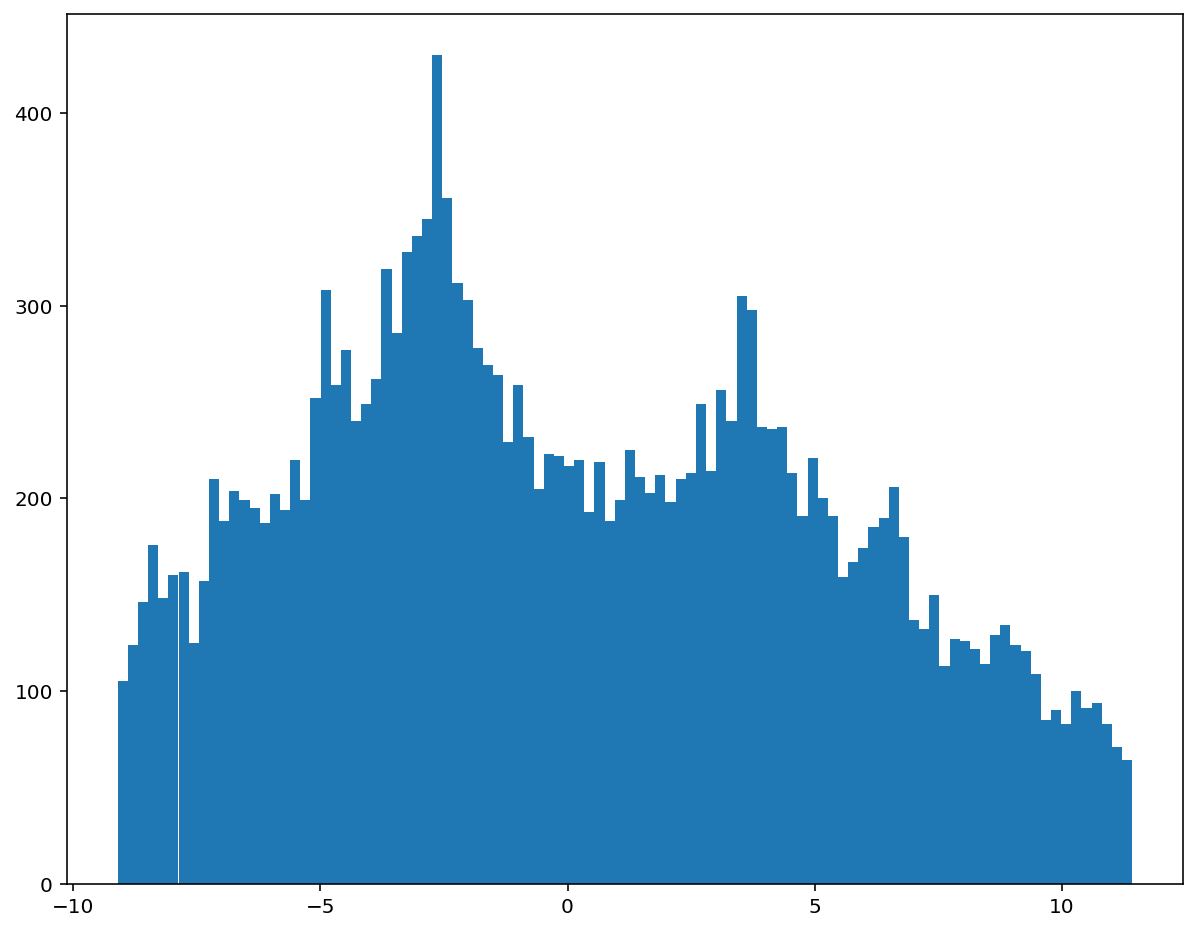

In [14]:
# Verificando a distibuição da série.
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(res[:,0],bins=100);

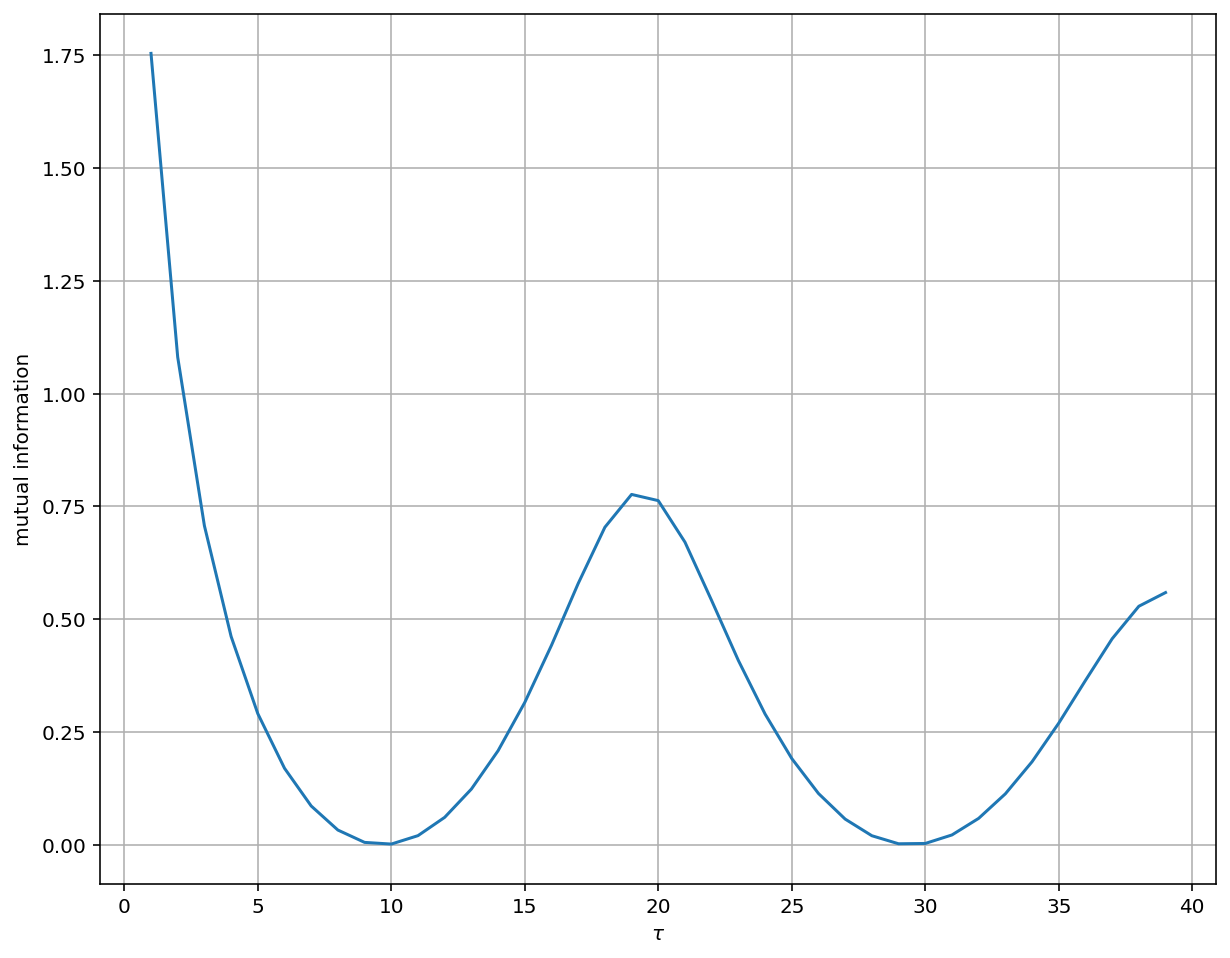

In [15]:
mis = []
for tau in range(1,40):
    mis.append(-0.5*np.log(1-pearsonr(res[:-tau,0],res[tau:,0])[0]**2))
#     mis.append(MI(res[:-tau,0],res[tau:,0]))
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(1,40),mis)
ax.grid()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'mutual information');

## Estimando $m$, a dimensão de embedding
Para esta parte vamos nos utilizar da biblioteca [nolds](https://github.com/CSchoel/nolds): Non-linear measures for Dynamical Systems. Nela temos a implementação do algoritmo  de Grassberger-Procaccia para cálculo da dimensão de correlação. Também vamos usar a biblioteca [Neurokit2](https://neurokit2.readthedocs.io) para estimação de dimensão de embedding.

In [16]:
import nolds
import neurokit2 as nk

In [6]:
nolds.corr_dim(res[:,0],4)

{'Delay': 9, 'Dimension': 3, 'Tolerance': 0.6197676049723305}

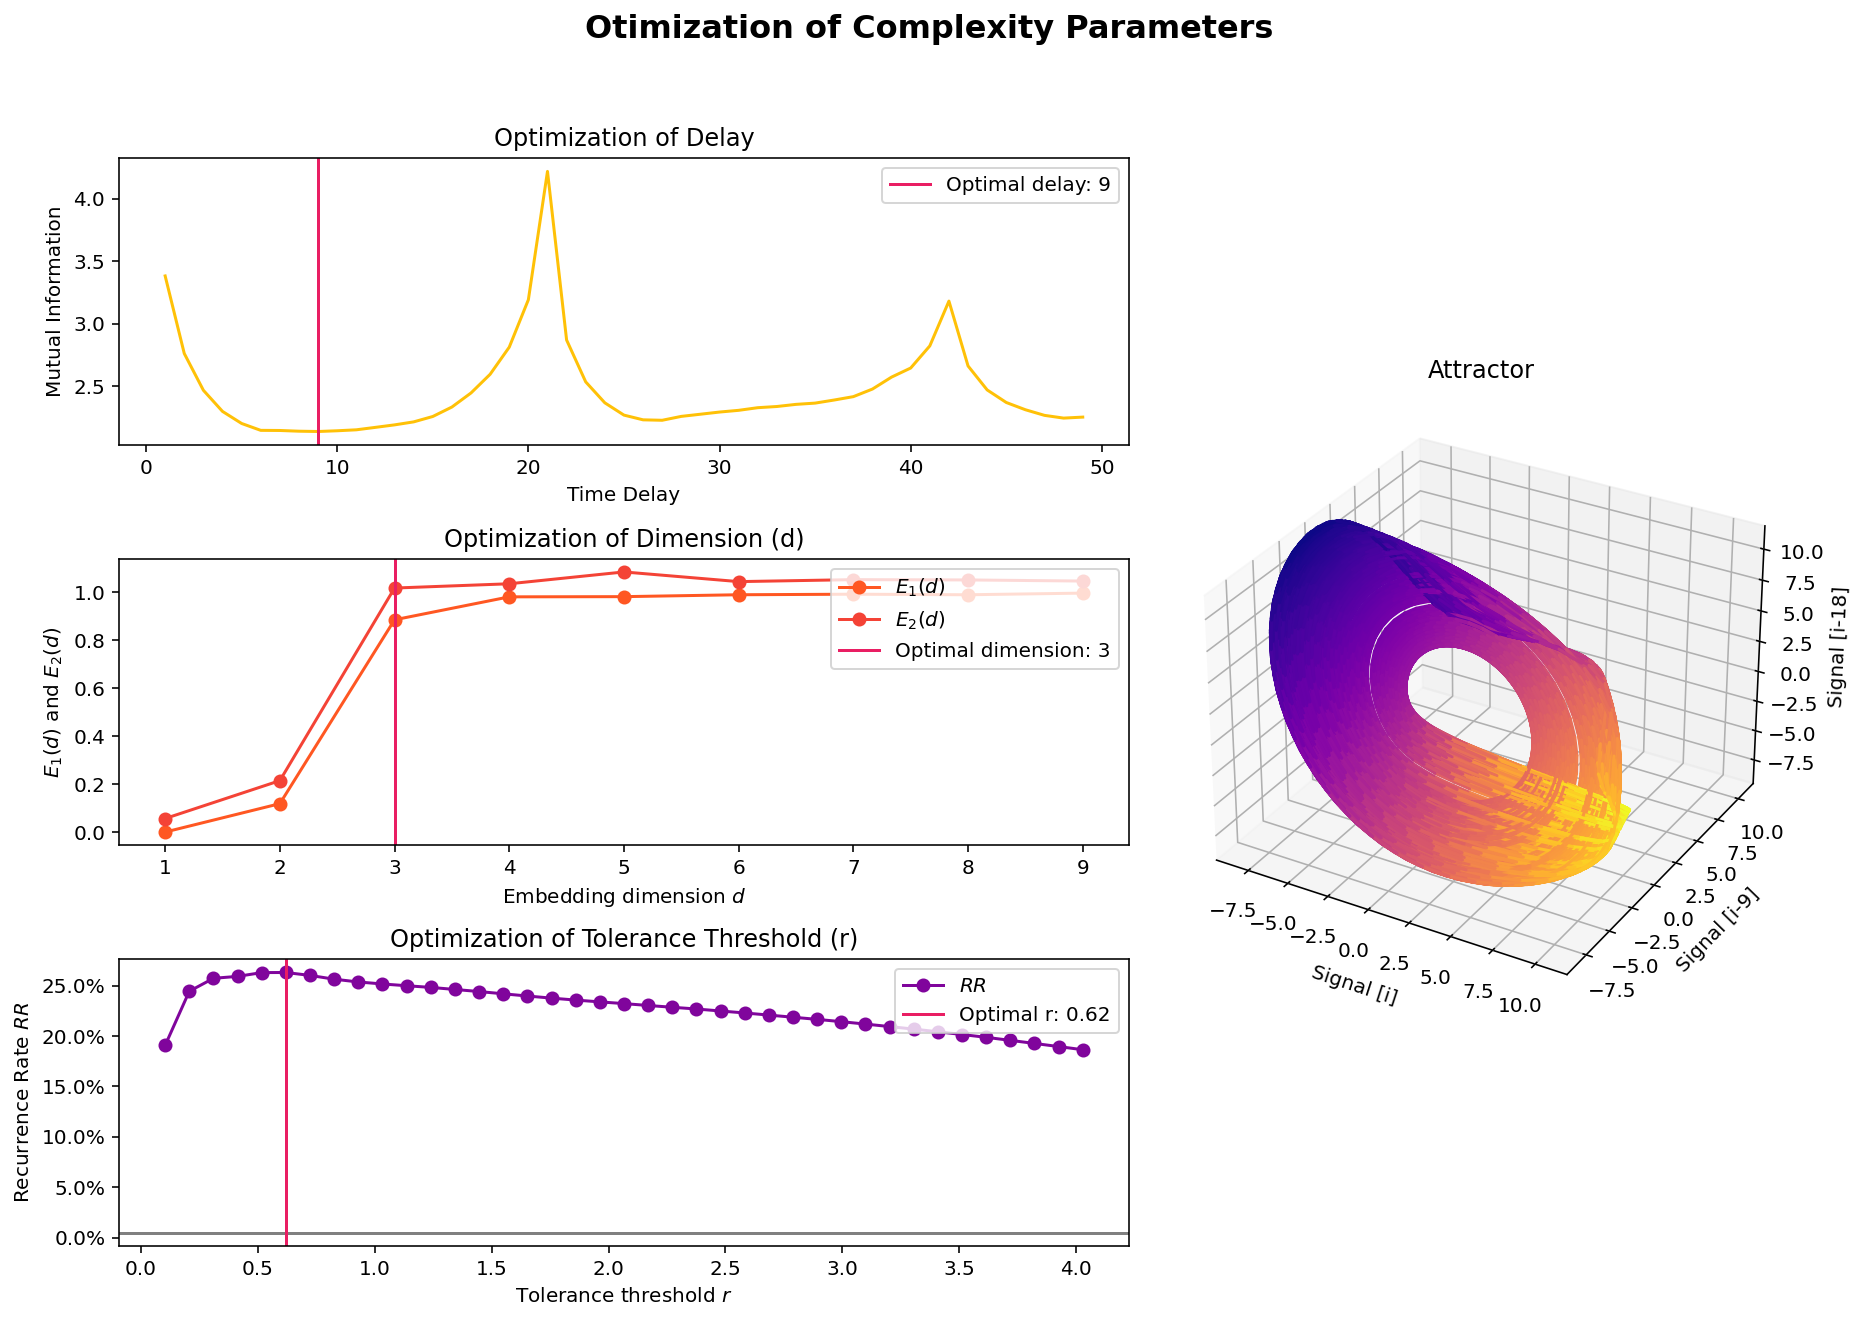

In [17]:
parameters = nk.complexity_optimize(res[:,0], show=True)
parameters

## Fazendo previsões a partir do sinal reconstruído.
Para testar a utilidade da reconstrução realizada, vamos utilizar uma regressão usando Kernel regression e também Lightgbm.

In [18]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from statsmodels.nonparametric.kernel_regression import KernelReg

In [19]:
data = pd.DataFrame(data={'ts':res[:,0]})
tau = 9
data['lag1'] = data.ts.shift(1*tau)
data['lag2'] = data.ts.shift(2*tau)
data['lag3'] = data.ts.shift(3*tau)
#data['lag4'] = data.ts.shift(4*tau)
data

,ts,lag1,lag2,lag3
0,4.000000,NaN,NaN,NaN
1,2.706346,NaN,NaN,NaN
2,1.556661,NaN,NaN,NaN
3,0.536866,NaN,NaN,NaN
4,-0.399581,NaN,NaN,NaN
...,...,...,...,...
19995,2.195639,8.182138,-3.532225,-7.676701
19996,0.611021,9.092300,-2.308254,-7.916135
19997,-0.505954,9.790064,-0.994711,-7.982260
19998,-1.359329,10.217218,0.381033,-7.868324


Agora vamos remover as primeiras linhas que contém `NaN`s

In [20]:
data = data.dropna()
data

,ts,lag1,lag2,lag3
27,2.900744,-5.698040,-4.463018,4.000000
28,4.019975,-5.126992,-5.096380,2.706346
29,5.079596,-4.421707,-5.632491,1.556661
30,6.052515,-3.594222,-6.056267,0.536866
31,6.912033,-2.659738,-6.354679,-0.399581
...,...,...,...,...
19995,2.195639,8.182138,-3.532225,-7.676701
19996,0.611021,9.092300,-2.308254,-7.916135
19997,-0.505954,9.790064,-0.994711,-7.982260
19998,-1.359329,10.217218,0.381033,-7.868324


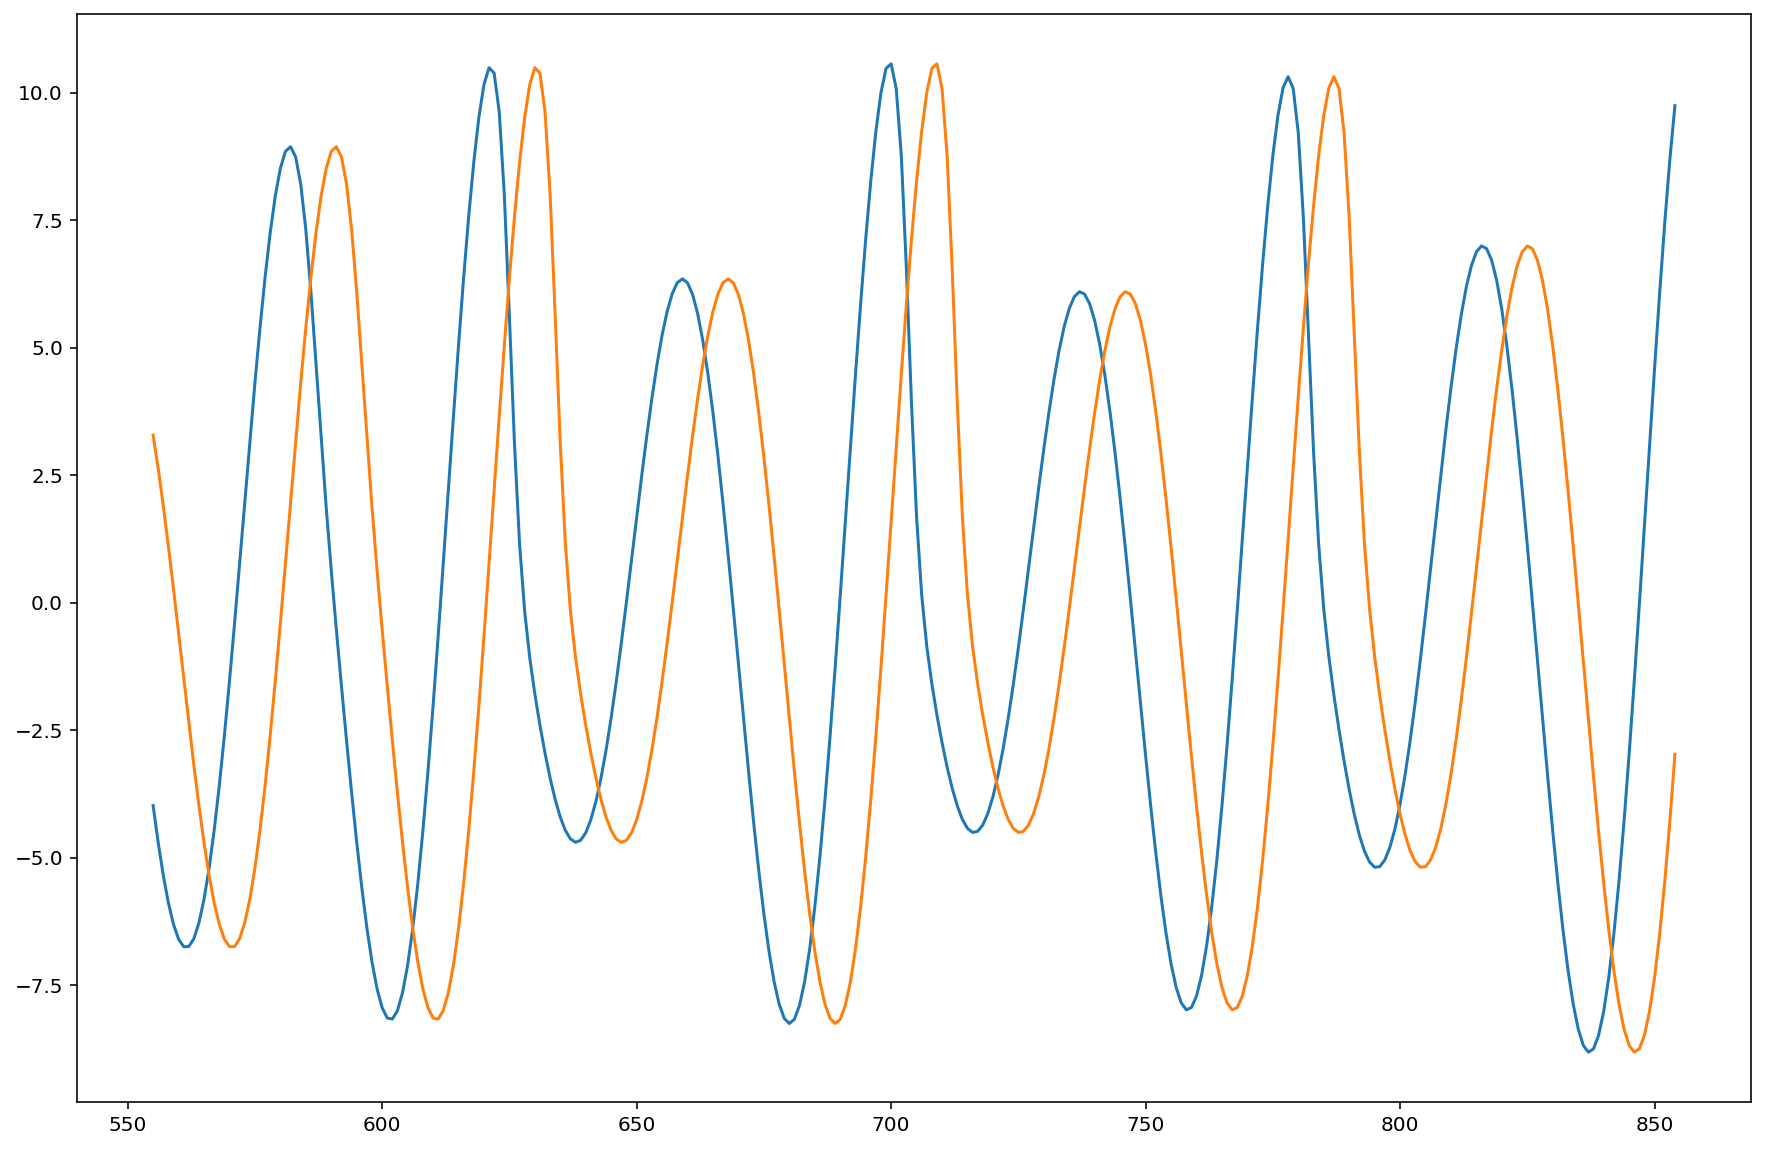

In [33]:
plt.plot(data[['ts','lag1']].iloc[528:828])

### Kernel regression
Vamos usar a biblioteca statsmodels para ajustar a [regressão de kernel](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_regression.KernelReg.html#statsmodels.nonparametric.kernel_regression.KernelReg) não paramétrica. Para economizar tempo, vamos ajustar a regressão por Kernel utilizando apenas os primeiros 500 pontos. So we will use only the first 500 points to fit the regression model.

In [43]:
model = KernelReg(data.ts[28:128], data[['lag1','lag2','lag3']][28:128],var_type=['c','c','c'])

Agora vamos usar os 500 pontos seguintes para testar o poder preditivo do modelo.

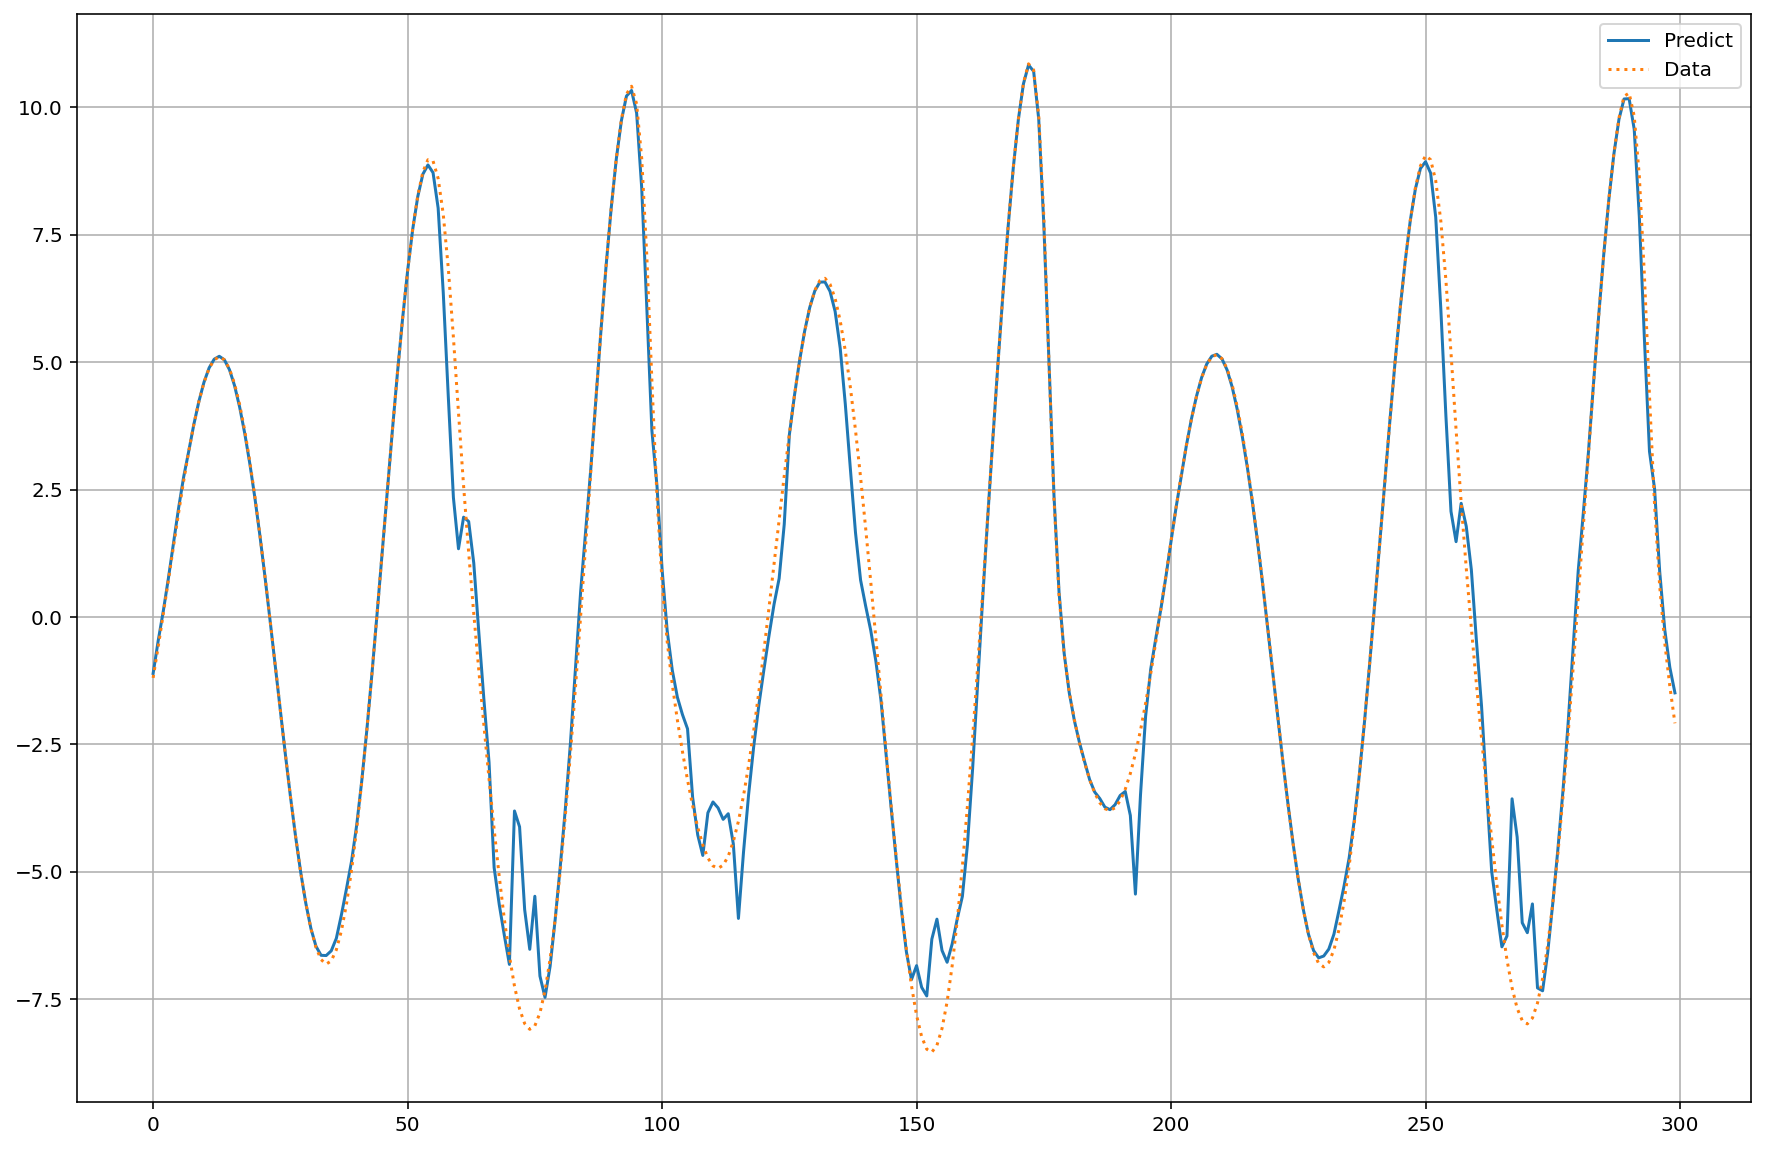

In [44]:
m,marg = model.fit(data_predict=data[['lag1','lag2','lag3']][-300:])
plt.plot(m, label='Predict')
plt.plot(range(300),data.ts[-300:],':',label='Data')
plt.grid()
plt.legend();

In [36]:
model.r_squared()

0.9998694279996977

### LightGBM regression

In [46]:
from flaml import AutoML
automl = AutoML()

In [54]:
train_size = 100
dftrain = data[['lag1','lag2','lag3',]][28:train_size+28]
dftest = data[['lag1','lag2','lag3',]][train_size+28:train_size+28+300]
Y = data.ts[28:train_size+28]

In [55]:
X_train, X_test, y_train, y_test = train_test_split( dftrain, Y, test_size=0.2, random_state=42)

In [56]:
automl_settings = {
    "time_budget": 10,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "reg.log",
    #"estimator_list": ["lgbm"]
}
automl.fit(X_train, y_train, **automl_settings)

[flaml.automl: 07-15 19:51:07] {2427} INFO - task = regression


[flaml.automl: 07-15 19:51:07] {2429} INFO - Data split method: uniform


[flaml.automl: 07-15 19:51:07] {2432} INFO - Evaluation method: cv


[flaml.automl: 07-15 19:51:07] {2551} INFO - Minimizing error metric: 1-r2


[flaml.automl: 07-15 19:51:07] {2691} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']


[flaml.automl: 07-15 19:51:07] {2993} INFO - iteration 0, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3126} INFO - Estimated sufficient time budget=581s. Estimated necessary time budget=5s.


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.1s,	estimator lgbm's best error=0.8563,	best estimator lgbm's best error=0.8563


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 1, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.1s,	estimator lgbm's best error=0.8563,	best estimator lgbm's best error=0.8563


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 2, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.2s,	estimator lgbm's best error=0.3746,	best estimator lgbm's best error=0.3746


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 3, current learner xgboost


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.2s,	estimator xgboost's best error=0.6772,	best estimator lgbm's best error=0.3746


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 4, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.3s,	estimator lgbm's best error=0.2159,	best estimator lgbm's best error=0.2159


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 5, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.4s,	estimator lgbm's best error=0.2159,	best estimator lgbm's best error=0.2159


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 6, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.4s,	estimator lgbm's best error=0.2159,	best estimator lgbm's best error=0.2159


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 7, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.5s,	estimator lgbm's best error=0.2159,	best estimator lgbm's best error=0.2159


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 8, current learner lgbm


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.5s,	estimator lgbm's best error=0.1739,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 9, current learner xgboost


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.6s,	estimator xgboost's best error=0.6772,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 10, current learner extra_tree


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.7s,	estimator extra_tree's best error=0.3864,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 11, current learner xgboost


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.8s,	estimator xgboost's best error=0.3280,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 12, current learner extra_tree


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 0.8s,	estimator extra_tree's best error=0.2854,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 13, current learner rf


[flaml.automl: 07-15 19:51:08] {3173} INFO -  at 1.0s,	estimator rf's best error=0.3740,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:08] {2993} INFO - iteration 14, current learner rf


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.1s,	estimator rf's best error=0.2446,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 15, current learner xgboost


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.3s,	estimator xgboost's best error=0.2155,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 16, current learner rf


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.6s,	estimator rf's best error=0.2446,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 17, current learner extra_tree


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.7s,	estimator extra_tree's best error=0.2354,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 18, current learner lgbm


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.8s,	estimator lgbm's best error=0.1739,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 19, current learner xgboost


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.8s,	estimator xgboost's best error=0.2155,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 20, current learner rf


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 1.9s,	estimator rf's best error=0.2393,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 21, current learner xgboost


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 2.0s,	estimator xgboost's best error=0.2155,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 22, current learner lgbm


[flaml.automl: 07-15 19:51:09] {3173} INFO -  at 2.0s,	estimator lgbm's best error=0.1739,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:09] {2993} INFO - iteration 23, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.1s,	estimator lgbm's best error=0.1739,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 24, current learner extra_tree


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.2s,	estimator extra_tree's best error=0.2143,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 25, current learner extra_tree


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.3s,	estimator extra_tree's best error=0.2143,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 26, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.3s,	estimator lgbm's best error=0.1739,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 27, current learner xgboost


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.4s,	estimator xgboost's best error=0.2155,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 28, current learner extra_tree


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.5s,	estimator extra_tree's best error=0.2143,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 29, current learner extra_tree


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.6s,	estimator extra_tree's best error=0.2143,	best estimator lgbm's best error=0.1739


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 30, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.6s,	estimator lgbm's best error=0.1659,	best estimator lgbm's best error=0.1659


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 31, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.7s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 32, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.7s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 33, current learner xgboost


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.8s,	estimator xgboost's best error=0.1930,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 34, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.9s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 35, current learner lgbm


[flaml.automl: 07-15 19:51:10] {3173} INFO -  at 2.9s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:10] {2993} INFO - iteration 36, current learner extra_tree


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.1s,	estimator extra_tree's best error=0.1788,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 37, current learner lgbm


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.2s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 38, current learner extra_tree


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.4s,	estimator extra_tree's best error=0.1788,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 39, current learner lgbm


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.5s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 40, current learner xgboost


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.6s,	estimator xgboost's best error=0.1930,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 41, current learner extra_tree


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.7s,	estimator extra_tree's best error=0.1715,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 42, current learner lgbm


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 3.9s,	estimator lgbm's best error=0.1602,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 43, current learner extra_tree


[flaml.automl: 07-15 19:51:11] {3173} INFO -  at 4.0s,	estimator extra_tree's best error=0.1715,	best estimator lgbm's best error=0.1602


[flaml.automl: 07-15 19:51:11] {2993} INFO - iteration 44, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.1s,	estimator extra_tree's best error=0.1276,	best estimator extra_tree's best error=0.1276


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 45, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.2s,	estimator extra_tree's best error=0.1276,	best estimator extra_tree's best error=0.1276


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 46, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.3s,	estimator extra_tree's best error=0.1264,	best estimator extra_tree's best error=0.1264


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 47, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.4s,	estimator extra_tree's best error=0.1264,	best estimator extra_tree's best error=0.1264


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 48, current learner xgboost


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.5s,	estimator xgboost's best error=0.1930,	best estimator extra_tree's best error=0.1264


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 49, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.6s,	estimator extra_tree's best error=0.1264,	best estimator extra_tree's best error=0.1264


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 50, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.7s,	estimator extra_tree's best error=0.1185,	best estimator extra_tree's best error=0.1185


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 51, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 4.8s,	estimator extra_tree's best error=0.1185,	best estimator extra_tree's best error=0.1185


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 52, current learner extra_tree


[flaml.automl: 07-15 19:51:12] {3173} INFO -  at 5.0s,	estimator extra_tree's best error=0.0929,	best estimator extra_tree's best error=0.0929


[flaml.automl: 07-15 19:51:12] {2993} INFO - iteration 53, current learner extra_tree


[flaml.automl: 07-15 19:51:13] {3173} INFO -  at 5.1s,	estimator extra_tree's best error=0.0929,	best estimator extra_tree's best error=0.0929


[flaml.automl: 07-15 19:51:13] {2993} INFO - iteration 54, current learner rf


[flaml.automl: 07-15 19:51:13] {3173} INFO -  at 5.2s,	estimator rf's best error=0.2343,	best estimator extra_tree's best error=0.0929


[flaml.automl: 07-15 19:51:13] {2993} INFO - iteration 55, current learner extra_tree


[flaml.automl: 07-15 19:51:13] {3173} INFO -  at 5.4s,	estimator extra_tree's best error=0.0929,	best estimator extra_tree's best error=0.0929


[flaml.automl: 07-15 19:51:13] {2993} INFO - iteration 56, current learner extra_tree


[flaml.automl: 07-15 19:51:13] {3173} INFO -  at 5.6s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:13] {2993} INFO - iteration 57, current learner extra_tree


[flaml.automl: 07-15 19:51:13] {3173} INFO -  at 5.8s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:13] {2993} INFO - iteration 58, current learner extra_tree


[flaml.automl: 07-15 19:51:13] {3173} INFO -  at 6.0s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:13] {2993} INFO - iteration 59, current learner rf


[flaml.automl: 07-15 19:51:14] {3173} INFO -  at 6.0s,	estimator rf's best error=0.2259,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:14] {2993} INFO - iteration 60, current learner extra_tree


[flaml.automl: 07-15 19:51:14] {3173} INFO -  at 6.3s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:14] {2993} INFO - iteration 61, current learner rf


[flaml.automl: 07-15 19:51:14] {3173} INFO -  at 6.3s,	estimator rf's best error=0.2150,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:14] {2993} INFO - iteration 62, current learner extra_tree


[flaml.automl: 07-15 19:51:14] {3173} INFO -  at 6.5s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:14] {2993} INFO - iteration 63, current learner extra_tree


[flaml.automl: 07-15 19:51:14] {3173} INFO -  at 6.9s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:14] {2993} INFO - iteration 64, current learner catboost


[flaml.automl: 07-15 19:51:15] {3173} INFO -  at 7.6s,	estimator catboost's best error=0.2284,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:15] {2993} INFO - iteration 65, current learner rf


[flaml.automl: 07-15 19:51:15] {3173} INFO -  at 7.7s,	estimator rf's best error=0.2073,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:15] {2993} INFO - iteration 66, current learner catboost


[flaml.automl: 07-15 19:51:16] {3173} INFO -  at 8.2s,	estimator catboost's best error=0.2284,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:16] {2993} INFO - iteration 67, current learner extra_tree


[flaml.automl: 07-15 19:51:16] {3173} INFO -  at 8.5s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:16] {2993} INFO - iteration 68, current learner catboost


[flaml.automl: 07-15 19:51:16] {3173} INFO -  at 8.9s,	estimator catboost's best error=0.1968,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:16] {2993} INFO - iteration 69, current learner rf


[flaml.automl: 07-15 19:51:16] {3173} INFO -  at 9.0s,	estimator rf's best error=0.2073,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:16] {2993} INFO - iteration 70, current learner extra_tree


[flaml.automl: 07-15 19:51:17] {3173} INFO -  at 9.2s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:17] {2993} INFO - iteration 71, current learner extra_tree


[flaml.automl: 07-15 19:51:17] {3173} INFO -  at 9.4s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:17] {2993} INFO - iteration 72, current learner xgboost


[flaml.automl: 07-15 19:51:17] {3173} INFO -  at 9.4s,	estimator xgboost's best error=0.1930,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:17] {2993} INFO - iteration 73, current learner extra_tree


[flaml.automl: 07-15 19:51:17] {3173} INFO -  at 9.6s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:17] {2993} INFO - iteration 74, current learner extra_tree


[flaml.automl: 07-15 19:51:17] {3173} INFO -  at 9.8s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:17] {2993} INFO - iteration 75, current learner extra_tree


[flaml.automl: 07-15 19:51:17] {3173} INFO -  at 10.0s,	estimator extra_tree's best error=0.0886,	best estimator extra_tree's best error=0.0886


[flaml.automl: 07-15 19:51:17] {3437} INFO - retrain extra_tree for 0.0s


[flaml.automl: 07-15 19:51:17] {3444} INFO - retrained model: ExtraTreesRegressor(max_features=0.7802880806859577, max_leaf_nodes=25,
                    n_estimators=27, n_jobs=-1)


[flaml.automl: 07-15 19:51:18] {2722} INFO - fit succeeded


[flaml.automl: 07-15 19:51:18] {2723} INFO - Time taken to find the best model: 5.575865268707275


In [57]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))

Best hyperparmeter config: {'n_estimators': 27, 'max_features': 0.7802880806859577, 'max_leaves': 25}
Best r2 on validation data: 0.9114


In [58]:
y_pred = automl.predict(dftest)

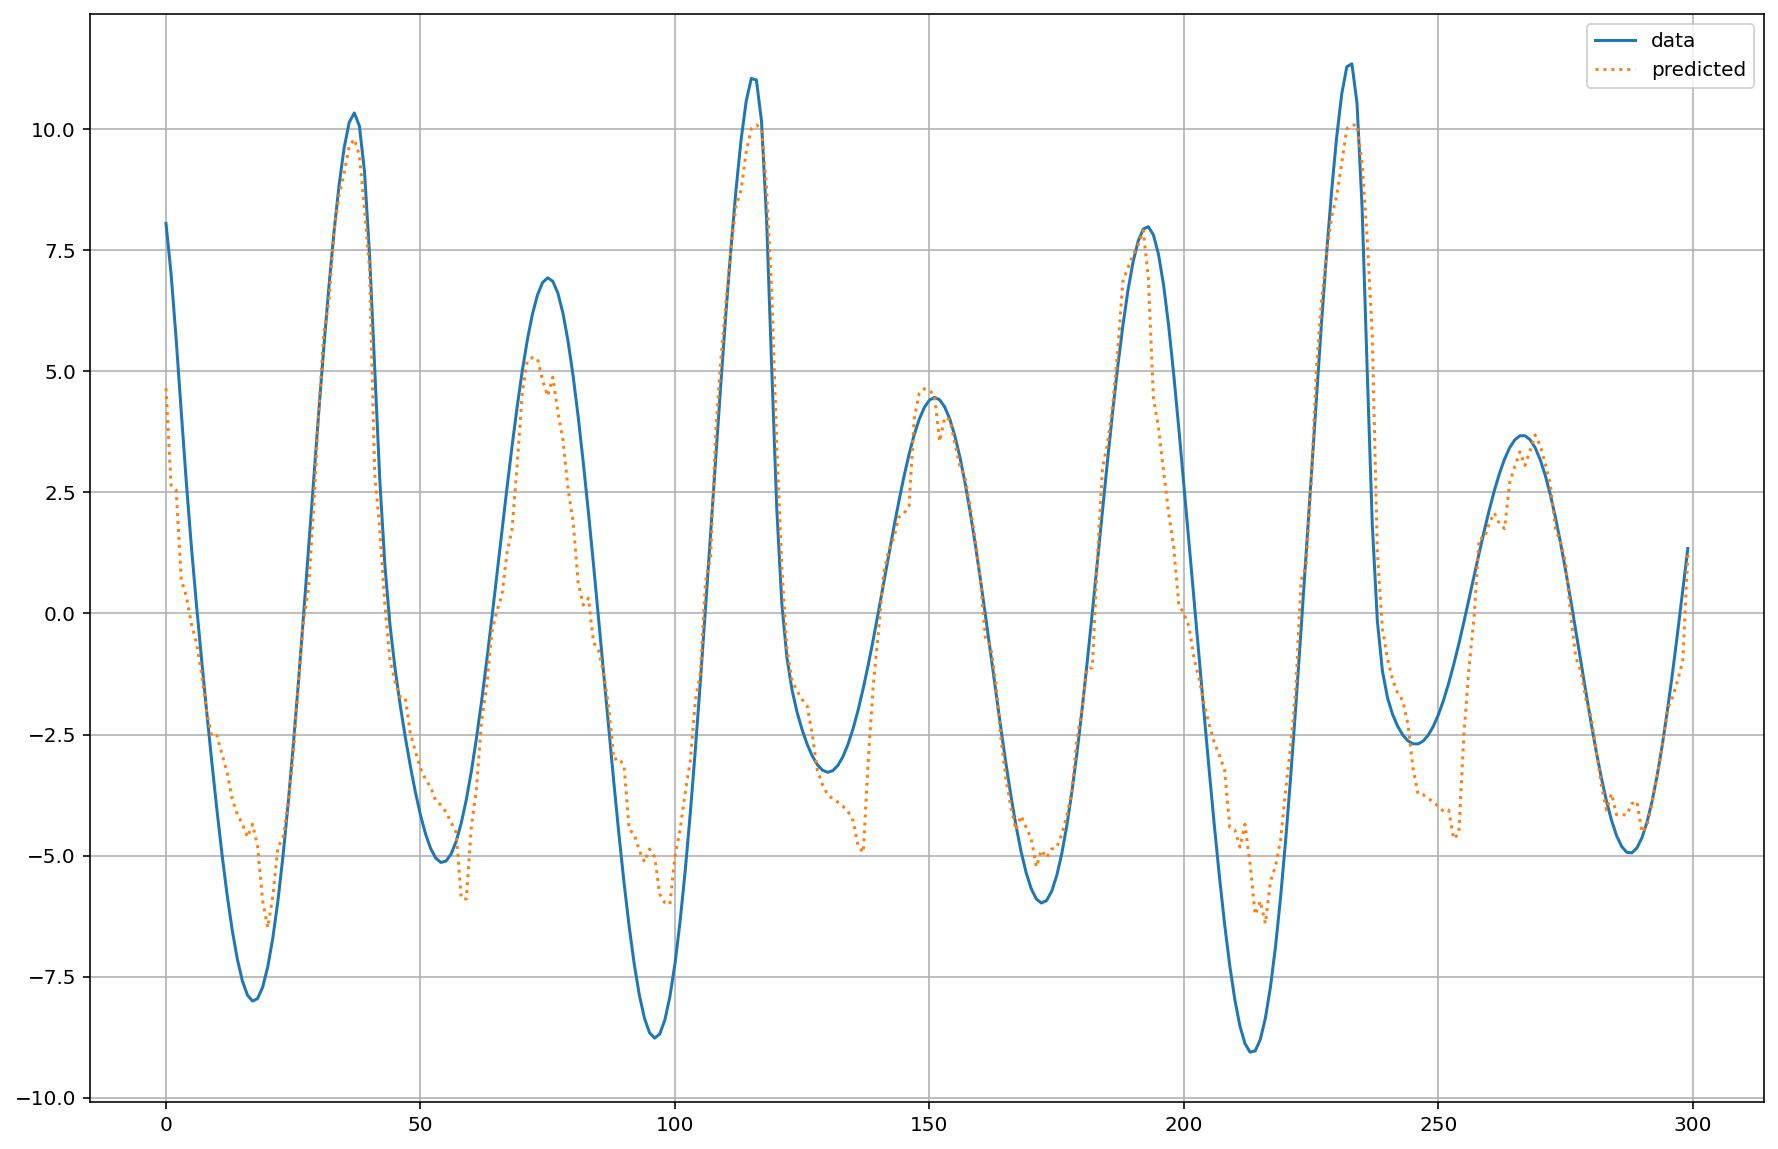

In [59]:
test_size = len(dftest)
plt.plot(range(300),data.ts[train_size+28:train_size+28+300], label='data')
plt.plot(y_pred,':',label='predicted')
plt.grid()
plt.legend();